<a href="https://colab.research.google.com/github/ArthurSampaio13/TimeSeries/blob/main/Nixtla2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importando as bibliotecas

In [ ]:
!pip install mlforecast

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.2/65.2 kB 702.4 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.5/193.5 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.3/40.3 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 5.0 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

import warnings
warnings.filterwarnings('ignore')

from mlforecast import MLForecast
from mlforecast.lag_transforms import ExpandingMean, RollingMean
from mlforecast.target_transforms import Differences
from utilsforecast.plotting import plot_series
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from mlforecast.target_transforms import LocalStandardScaler

import lightgbm as lgb
from sklearn.base import BaseEstimator
from sklearn.linear_model import Lasso, LinearRegression, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor

from mlforecast.lag_transforms import ExpandingMean, RollingMean, ExpandingStd
from mlforecast.target_transforms import Differences

from sklearn.neural_network import MLPRegressor
from mlforecast.core import Lag

from mlforecast import MLForecast
from mlforecast.target_transforms import BaseTargetTransform, Differences, LocalMinMaxScaler
from mlforecast.utils import generate_daily_series
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PowerTransformer

from mlforecast.utils import PredictionIntervals

from utilsforecast.losses import mae, mape, rmse, smape
from utilsforecast.evaluation import evaluate

from xgboost.sklearn import XGBRegressor
import lightgbm as lgb
from sklearn.linear_model import LinearRegression

from pylab import rcParams
rcParams['figure.figsize'] = (16, 8)

# Candy production

## Leitura dos dados

In [ ]:
dados = pd.read_csv('/content/candy_production.csv',
                    parse_dates=['observation_date'])

## Adequando o DF para o Nixtla

In [ ]:
def df_nixtla(df, target):
    df.rename(columns={"observation_date": "ds", target: "y"}, inplace=True)
    df["unique_id"] = "1"
    df['ds'] = pd.to_datetime(df['ds'])

    return df

In [ ]:
dados = df_nixtla(dados, 'IPG3113N')

In [ ]:
dados.head()

,ds,y,unique_id
0,1972-01-01,85.6945,1
1,1972-02-01,71.8200,1
2,1972-03-01,66.0229,1
3,1972-04-01,64.5645,1
4,1972-05-01,65.0100,1


In [ ]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 548 entries, 0 to 547
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   ds         548 non-null    datetime64[ns]
 1   y          548 non-null    float64       
 2   unique_id  548 non-null    object        
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 13.0+ KB


## Explorando os dados

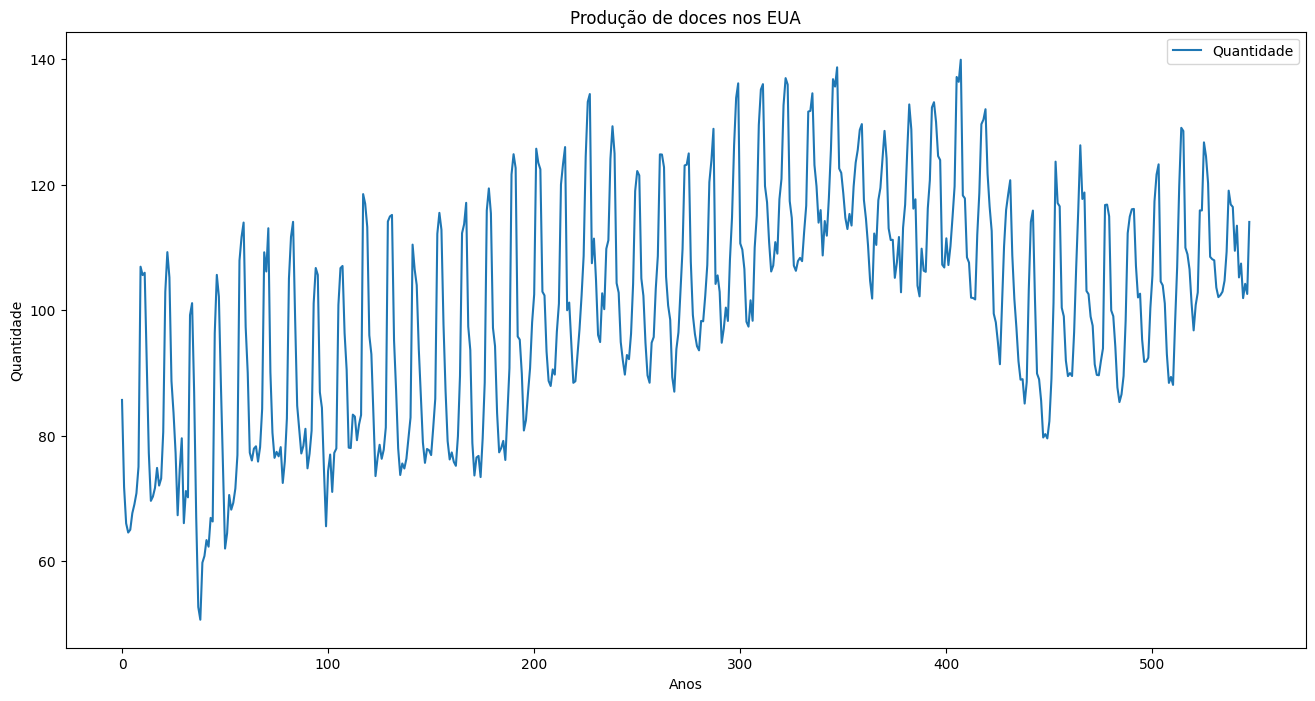

In [ ]:
plt.title("Produção de doces nos EUA")
plt.plot(dados['y'], label="Quantidade")
plt.xlabel("Anos")
plt.ylabel("Quantidade")
plt.legend(loc="best")
plt.show()

## Verificando estacionariedade

In [ ]:
def teste_estacionaria(serie):

  p_value = adfuller(serie)[1]

  print(p_value)

  if p_value < 0.05:
    print("Série estacionaria")

  else:
    print("Série não estacionaria")

teste_estacionaria(dados['y'])

0.33817759730043095
Série não estacionaria


In [ ]:
teste_estacionaria(dados['y'].diff().dropna())

8.925584203569585e-08
Série estacionaria


## Grafico ACF e PACF

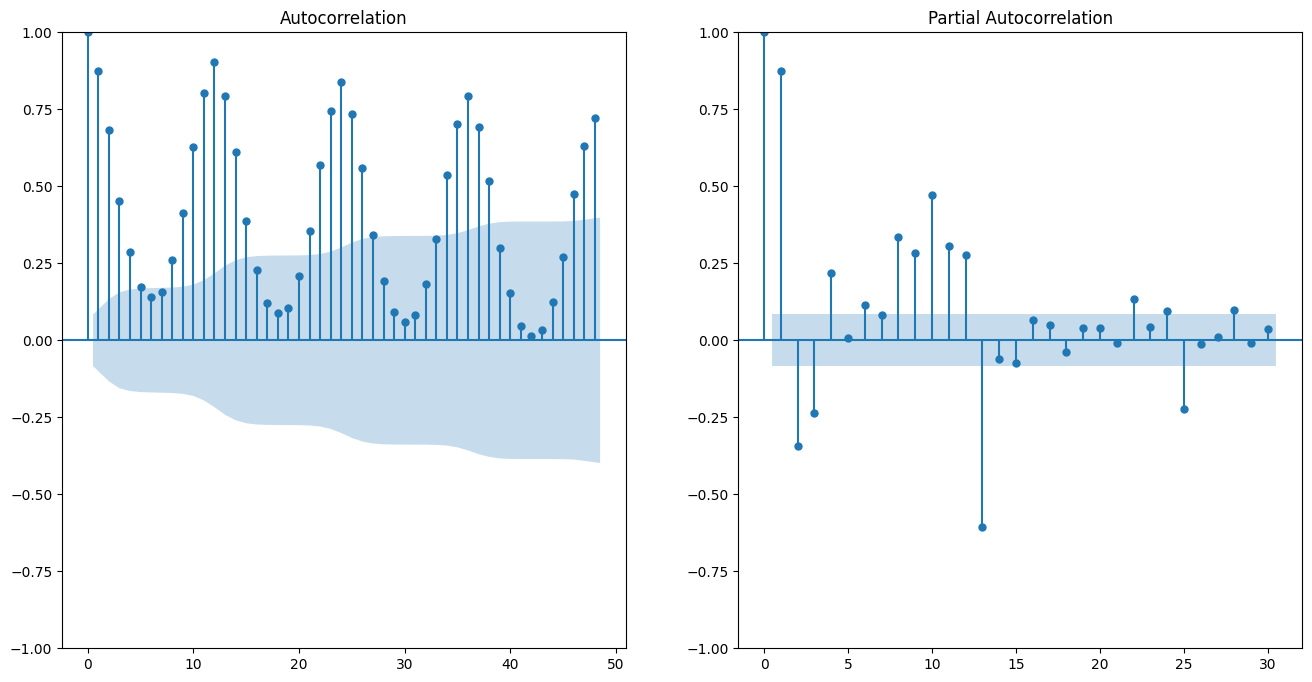

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=2)

plot_acf(dados["y"],  lags=48, ax=axs[0])
axs[0].set_title("Autocorrelation");

plot_pacf(dados["y"],  lags=30, ax=axs[1])
axs[1].set_title('Partial Autocorrelation')
plt.show();

## Decompondo a Series

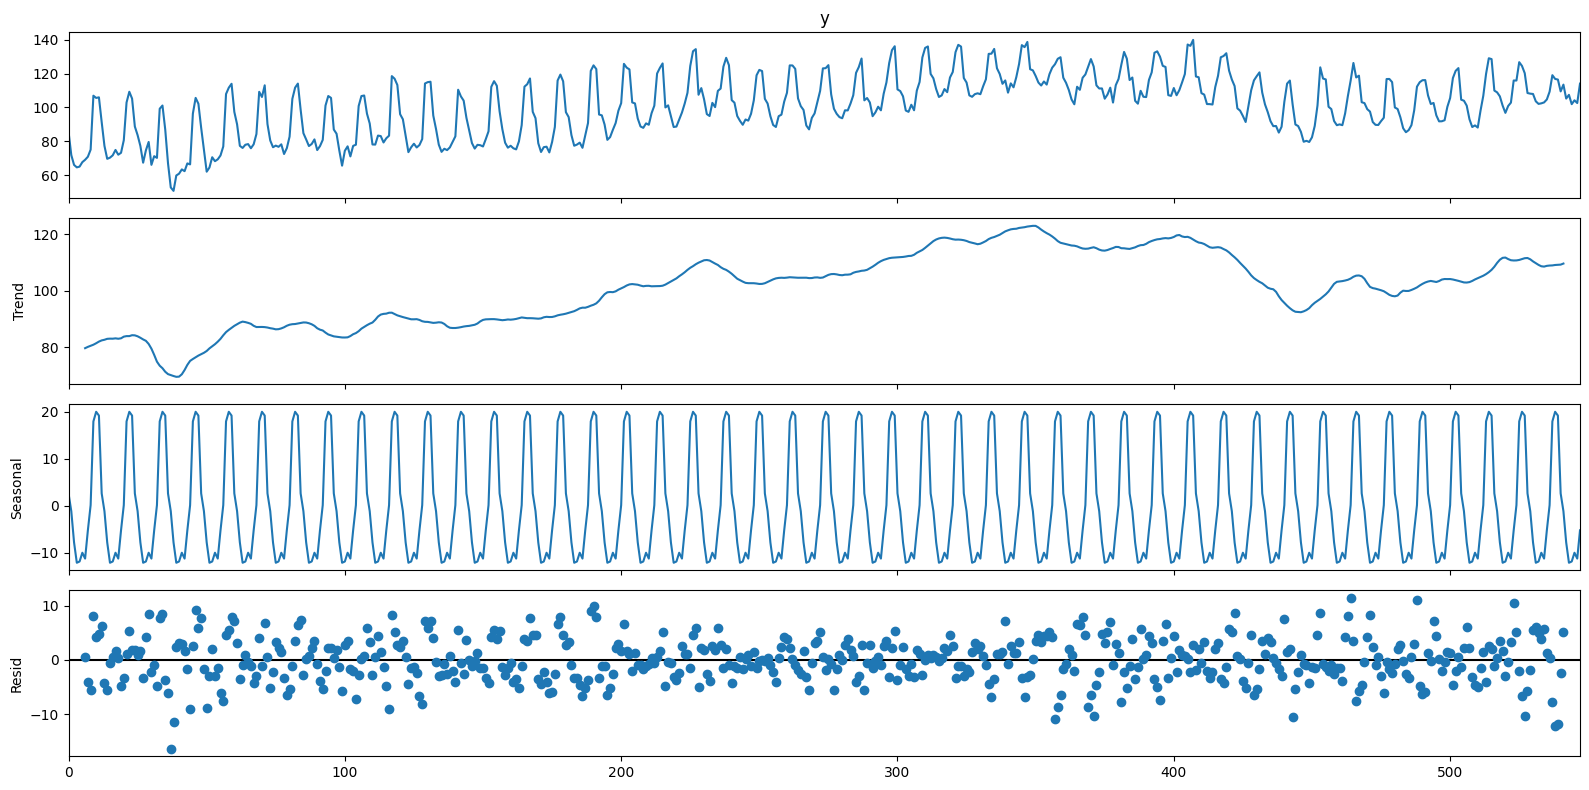

In [ ]:
a = seasonal_decompose(dados["y"], model = "additive", period=12).plot()
plt.show()

## Split em treino e teste

In [ ]:
dados = dados.loc[dados['ds'].dt.year != 2017]

> Removi por nao ser um ano completo

In [ ]:
train = dados[dados['ds'] < '2015']

test = dados[dados['ds'] >= '2015']

In [ ]:
train.shape, test.shape

((516, 3), (24, 3))

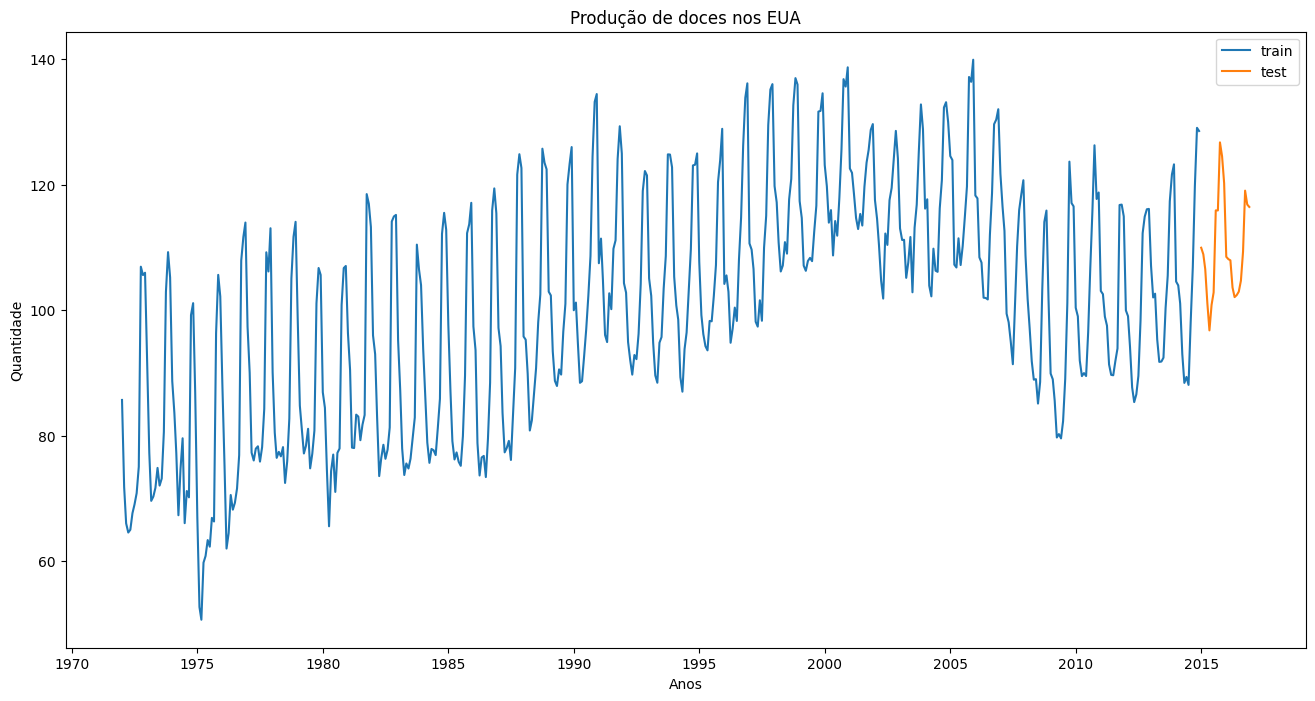

In [ ]:
plt.title("Produção de doces nos EUA")
plt.plot(train['ds'], train['y'], label="train")
plt.plot(test['ds'], test['y'], label="test")
plt.xlabel("Anos")
plt.ylabel("Quantidade")
plt.legend(loc="best")
plt.show()

## Previsão do meu modelo

> Aproveitei que é possível treinar vários modelos ao mesmo tempo para poder encontrar qual seria melhor para minha base de dados
- Ele permite todos os regressors do sklearn



>

## Criando um modelo baseline

In [ ]:
class Naive(BaseEstimator):
    def fit(self, X, y):
        return self

    def predict(self, X):
        return X['lag1']

> Dicionário dos modelos

In [ ]:
models = {
    'ran_fores' : RandomForestRegressor(),
    'mlp': MLPRegressor(),
    'ridge': Ridge(),
    'naive' : Naive(),
}

## Encontrando quais parametros fazem mais sentido para o meu modelo

In [ ]:
fcst = MLForecast(
    models = models,
    freq = 'MS',
    lags = [1, 12, 24, 36, 48],
    date_features = ['month',
                     'quarter'],
    target_transforms = [Differences([1]),
                         LocalMinMaxScaler()]
)

In [ ]:
prep = fcst.preprocess(train)
prep

,ds,y,unique_id,lag1,lag12,lag24,lag36,lag48,month,quarter
49,1976-02-01,0.228266,1,0.204874,0.203407,0.351834,0.208001,0.210498,2,1
50,1976-03-01,0.221707,1,0.228266,0.401080,0.331065,0.310486,0.340438,3,1
51,1976-04-01,0.473362,1,0.221707,0.579965,0.274289,0.444757,0.410235,4,2
52,1976-05-01,0.531337,1,0.473362,0.450851,0.551110,0.455954,0.440863,5,2
53,1976-06-01,0.396104,1,0.531337,0.474480,0.513587,0.484873,0.476112,6,2
...,...,...,...,...,...,...,...,...,...,...
511,2014-08-01,0.594324,1,0.413246,0.561256,0.574859,0.470102,0.599474,8,3
512,2014-09-01,0.575062,1,0.594324,0.516663,0.658474,0.466132,0.579851,9,3
513,2014-10-01,0.641202,1,0.575062,0.623990,0.476161,0.801399,0.601372,10,4
514,2014-11-01,0.583231,1,0.641202,0.502421,0.452518,0.434700,0.296027,11,4


In [ ]:
prep.drop(columns=['unique_id', 'ds']).corr()['y']

y          1.000000
lag1       0.262601
lag12      0.874864
lag24      0.835094
lag36      0.818480
lag48      0.827057
month      0.632736
quarter    0.635529
Name: y, dtype: float64

> Gostei dos resultados e utilizei esses

In [ ]:
fcst.fit(
    df = train,
    prediction_intervals=PredictionIntervals(n_windows=4, h=24)
)

MLForecast(models=[ran_fores, mlp, ridge, naive], freq=MS, lag_features=['lag1', 'lag12', 'lag24', 'lag36', 'lag48'], date_features=['month', 'quarter'], num_threads=1)

## Previsao teste

In [ ]:
forecasts = fcst.predict(len(test))
forecasts

,unique_id,ds,ran_fores,mlp,ridge,naive
0,1,2015-01-01,114.409721,114.002522,113.520323,128.0437
1,1,2015-02-01,112.187018,109.779536,111.658796,127.5346
2,1,2015-03-01,106.226497,102.332394,107.977378,127.0255
3,1,2015-04-01,102.111636,101.668740,102.242589,126.5164
4,1,2015-05-01,100.235222,99.115176,98.547194,126.0073
5,1,2015-06-01,99.329618,95.798810,98.779516,125.4982
6,1,2015-07-01,98.279208,101.710054,99.096843,124.9891
7,1,2015-08-01,106.429535,106.698878,106.014792,124.4800
8,1,2015-09-01,112.135711,108.232318,112.302930,123.9709
9,1,2015-10-01,126.813943,122.358741,124.358229,123.4618


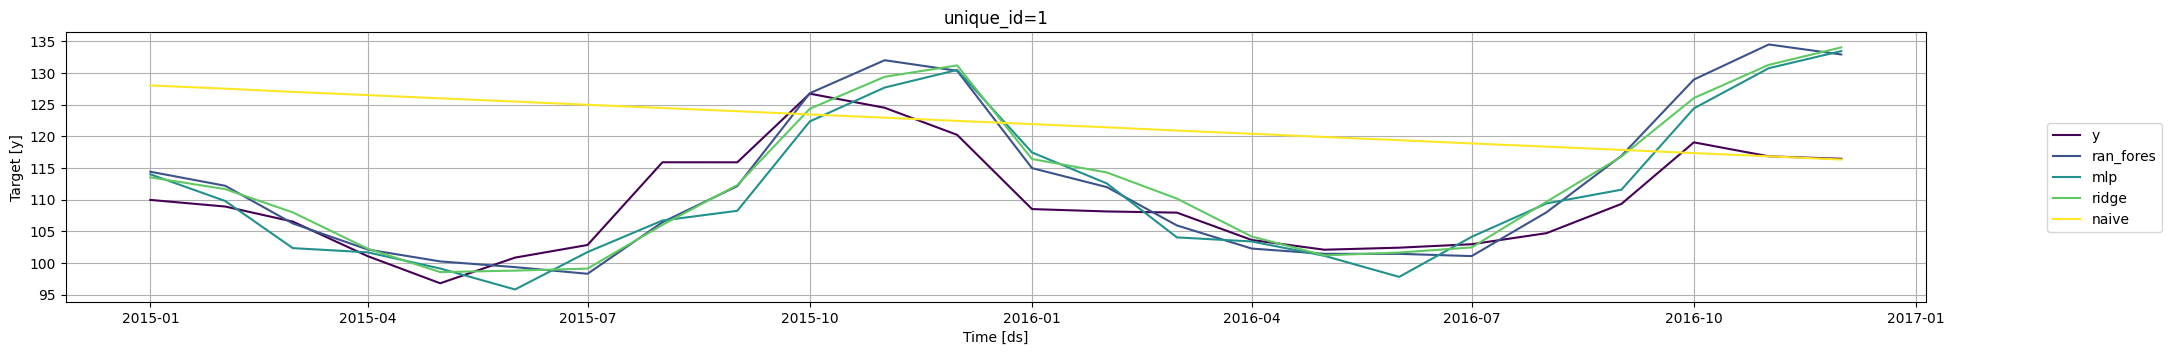

In [ ]:
plot_series(test, forecasts, max_insample_length=24)

## Avaliandos as metricas

In [ ]:
metrics = [mae, rmse, mape]

In [ ]:
previsao = test.merge(forecasts, how='right', on=['unique_id', 'ds'])
previsao.head()

,ds,y,unique_id,ran_fores,mlp,ridge,naive
0,2015-01-01,109.9525,1,114.409721,114.002522,113.520323,128.0437
1,2015-02-01,108.9073,1,112.187018,109.779536,111.658796,127.5346
2,2015-03-01,106.5261,1,106.226497,102.332394,107.977378,127.0255
3,2015-04-01,101.0631,1,102.111636,101.668740,102.242589,126.5164
4,2015-05-01,96.7802,1,100.235222,99.115176,98.547194,126.0073


In [ ]:
evaluate(
    df = previsao,
    metrics=metrics,
    models=list(models.keys())
)

,unique_id,metric,ran_fores,mlp,ridge,naive
0,1,mae,5.071767,5.018068,4.947586,13.069958
1,1,rmse,6.917546,6.530183,6.650381,15.522340
2,1,mape,0.044850,0.044574,0.043750,0.124606
